## ILAS - Data Mining (summer 2019) - Assignment 4
#### by Andreas Hene, Niklas Mertens, Richard Palme

In [1]:
%matplotlib inline

import time
import math
import os
import multiprocessing as mp

import sympy
import pandas
import numpy as np
import matplotlib.pyplot as plt

First we write a function `get_repr` that returns the representative of an element `val` in the dyadic interval of level `lvl`. The representative is always chosen to be the smallest element of the dyadic array.
$$ \text{val} = j \cdot 2^{h-\text{lvl}} + \text{rest} $$
The representative can be computed by
$$ j \cdot 2^{h-\text{lvl}} $$

In [2]:
def get_repr(val, lvl, h):
    return math.floor(val / 2**(h-lvl)) * 2**(h-lvl)

Next we write a function `get_children` that returns the children dyadic intervals of a representative `u`. The intervals are again given by their representative. The children of `u` are `u` and
$$ u + 2^{h-(\text{lvl} + 1)} $$

In [3]:
def get_children(u, lvl, h, n):
    children = [u]
    if lvl != h:
        right_child = u + 2**(h - (lvl+1))
        if right_child <= n:
            children.append(right_child)
    return children

In [4]:
def base_p(u, p, size):
    res = np.zeros(size, dtype=np.int16)
    i = 0
    while u != 0:
        u, r = np.divmod(u, p)
        res[i] = r
        i += 1
    return res

def _hashfunc(u, a, b, p, k):
    return (np.dot(a, base_p(u, p, k)) + b) % p

In [5]:
def readstream(chunk_num, chunk, h, d, p, hashpattern, point_query, return_dict):
    if not point_query:
        # note that, since w isn't necessarily a prime number,
        # we might have to make w larger (i.e. take p instead of w)
        C = np.zeros((h+1, d, p), dtype=np.int32)

        for x in chunk:
            for lvl in range(h+1):
                u = get_repr(x, lvl, h)
                np.add(C[lvl], hashpattern[u], out=C[lvl])
        return_dict[chunk_num] = C
    else:
        C = np.zeros((d, p), dtype=np.int32)
        for x in chunk:
            np.add(C, hashpattern[x], out=C)
        return_dict[chunk_num] = C

def count_min_sketch(filepath, eps=1e-2, delta=1e-10, point_query=False):
    with open(filepath) as f:
        n = int(f.readline())
        m = int(f.readline())
        threshold = int(f.readline())
    
    d = math.ceil(math.log(1.0 / delta, 2))
    w = math.ceil(2.0 / eps)
    
    # find a prime p with p >= w
    p = w
    while not sympy.isprime(p):
        p += 1

    # choose k such that p^k - 1 >= n
    # i.e. k >= log(n+1, p)
    k = math.ceil(math.log(n+1, p))

    hashfuncs = []
    for _ in range(d):
        a = np.asarray([np.random.randint(p) for _ in range(k)])
        b = np.random.randint(p)
        hashfuncs.append(lambda u, a=a, b=b: _hashfunc(u, a, b, p, k))

    hashpattern = np.zeros((n+1, d, p), dtype=np.int8)
    for u in range(n + 1):
        for i, hashfunc in enumerate(hashfuncs):
            hashpattern[(u, i, hashfunc(u))] = 1

    h = math.ceil(math.log(n, 2))

    num_cores = os.cpu_count()
    chunksize = math.ceil(m / num_cores)
    chunks = pandas.read_csv(
        filepath,
        header=None,
        skiprows=3,
        squeeze=True,
        dtype=np.int16,
        delim_whitespace=True,
        chunksize=chunksize
    )
    
    manager = mp.Manager()
    return_dict = manager.dict()
    jobs = []
    for i, chunk in enumerate(chunks):
        job = mp.Process(target=readstream, args=(i, chunk, h, d, p, hashpattern, point_query, return_dict))
        jobs.append(job)
        job.start()
    for proc in jobs:
        proc.join()
    
    if not point_query:
        # note that, since w isn't necessarily a prime number,
        # we might have to make w larger (i.e. take p instead of w)
        C = np.zeros((h+1, d, p), dtype=np.int32)
        for matrix in return_dict.values():
            np.add(C, matrix, out=C)
    
        # now we do BFS. the values in explore_current are
        # the representatives of the dyadic arrays that
        # currently get explored on this level.
        explore_current = [0]
        explore_next = []
        approx_freq = np.zeros(d, dtype=np.int32)
        for lvl in range(h + 1):
            for u in explore_current:
                for i, hashfunc in enumerate(hashfuncs):
                    approx_freq[i] = C[(lvl, i, hashfunc(u))]
                if approx_freq.min() >= threshold:
                    explore_next.extend(get_children(u, lvl, h, n))
            explore_current = explore_next
            explore_next = []

        # prepare the output:
        approx_frequency = []
        for u in explore_current:
            for i, hashfunc in enumerate(hashfuncs):
                approx_freq[i] = C[(h, i, hashfunc(u))]
            approx_frequency.append(approx_freq.min())

        return explore_current, approx_frequency

    C = np.zeros((d, p), dtype=np.int32)
    for matrix in return_dict.values():
        np.add(C, matrix, out=C)
    
    approx_frequency = []
    approx_freq = np.zeros(d, dtype=np.int32)
    for u in range(n + 1):
        for i, hashfunc in enumerate(hashfuncs):
            approx_freq[i] = C[(i, hashfunc(u))]
        approx_frequency.append(approx_freq.min())
    return list(range(n+1)), approx_frequency

In [6]:
def readstream_brute(chunk_num, chunk, n, return_dict):
    freq = np.zeros(n+1, dtype=np.int32)
    for u in chunk:
        freq[u] += 1
    return_dict[chunk_num] = freq

def brute(filepath, point_query=False):
    with open(filepath) as f:
        n = int(f.readline())
        m = int(f.readline())
        t = int(f.readline())
    
    num_cores = os.cpu_count()
    chunksize = math.ceil(m / num_cores)
    chunks = pandas.read_csv(
        filepath,
        header=None,
        skiprows=3,
        squeeze=True,
        dtype=np.int16,
        delim_whitespace=True,
        chunksize=chunksize
    )
    
    manager = mp.Manager()
    return_dict = manager.dict()
    jobs = []
    for i, chunk in enumerate(chunks):
        job = mp.Process(target=readstream_brute, args=(i, chunk, n, return_dict))
        jobs.append(job)
        job.start()
    for proc in jobs:
        proc.join()
       
    freq = np.zeros(n+1, dtype=np.int32)
    for arr in return_dict.values():
        np.add(freq, arr, out=freq)
    
    if not point_query:
        return [(i, f) for (i, f) in zip(range(n+1), freq) if f >= t]
    return [(i, f) for (i, f) in zip(range(n+1), freq)]

In [7]:
filename = [
    'data/easy.txt',
    'data/large_15k.txt',
    'data/large_25k.txt',
    'data/larger_40k.txt',
    'data/wide_1k.txt',
    'data/largest_40k.txt',
]

def run_countmin(filepath, eps=1e-2, delta=1e-10, point_query=False):
    start = time.time()
    result, freq = count_min_sketch(filepath, eps=eps, delta=delta, point_query=point_query)
    end = time.time()
    elapsed_time = int(round(end - start))

    print(filepath)
    print(list(zip(result, freq)))
    print('time in seconds:', elapsed_time)
    print()
    
def run_brute(filepath, point_query=False):
    start = time.time()
    result = brute(filepath, point_query=point_query)
    end = time.time()
    elapsed_time = int(round(end - start))

    print(filepath)
    print(result)
    print()
    print('time in seconds:', elapsed_time)
    print()

In [8]:
for filepath in filename:
    run_brute(filepath)

data/easy.txt
[(4, 38313), (8, 38298)]

time in seconds: 0

data/large_15k.txt
[(1079, 16261), (1080, 17619), (1081, 19139), (1082, 20809), (1083, 22552), (1084, 23643), (1085, 24202), (1086, 25485), (1087, 25951), (1088, 26327), (1089, 26725), (1090, 26522), (1091, 26231), (1092, 25085), (1093, 24463), (1094, 23421), (1095, 22264), (1096, 20880), (1097, 19277), (1098, 17872), (1099, 16061)]

time in seconds: 1

data/large_25k.txt
[(1086, 25485), (1087, 25951), (1088, 26327), (1089, 26725), (1090, 26522), (1091, 26231), (1092, 25085)]

time in seconds: 1

data/larger_40k.txt
[(510, 46055), (511, 53417), (512, 58623), (513, 62742), (514, 63680), (515, 62788), (516, 58635), (517, 53544), (518, 46366)]

time in seconds: 3

data/wide_1k.txt
[(4369, 1261), (4370, 1251), (4371, 1385), (4372, 1326), (4373, 1400), (4374, 1455), (4375, 1530), (4376, 1634), (4377, 1584), (4378, 1666), (4379, 1707), (4380, 1686), (4381, 1727), (4382, 1667), (4383, 1835), (4384, 1894), (4385, 1799), (4386, 1840), 

In [17]:
for filepath in filename:
    run_countmin(filepath, eps=1e-2, delta=1e-10)

data/easy.txt
[(4, 38313), (8, 38298)]
time in seconds: 2

data/large_15k.txt
[(1079, 16262), (1080, 17620), (1081, 19142), (1082, 20812), (1083, 22553), (1084, 23644), (1085, 24203), (1086, 25486), (1087, 25952), (1088, 26328), (1089, 26726), (1090, 26523), (1091, 26232), (1092, 25086), (1093, 24464), (1094, 23422), (1095, 22265), (1096, 20881), (1097, 19280), (1098, 17873), (1099, 16062)]
time in seconds: 54

data/large_25k.txt
[(1086, 25488), (1087, 25953), (1088, 26329), (1089, 26731), (1090, 26528), (1091, 26234), (1092, 25091)]
time in seconds: 52

data/larger_40k.txt
[(509, 41230), (510, 48817), (511, 56220), (512, 61362), (513, 65452), (514, 66453), (515, 65927), (516, 61841), (517, 56782), (518, 49781), (519, 41805)]
time in seconds: 102

data/wide_1k.txt
[(976, 6850), (977, 6694), (978, 6803), (979, 6744), (980, 6834), (981, 6831), (982, 6766), (983, 6551), (984, 6764), (985, 6742), (986, 6802), (987, 6740), (988, 6635), (989, 6561), (990, 6544), (991, 6465), (992, 6589), (99

data/largest_40k.txt
[(240, 100379), (241, 100271), (242, 100868), (243, 100025), (244, 100336), (245, 100598), (246, 100262), (282, 100625), (283, 100908), (284, 101389), (285, 101437), (286, 100906), (287, 101875), (288, 101496), (289, 100726), (531, 106475), (532, 137759), (533, 172934), (534, 211074), (535, 248770), (536, 284110), (537, 311605), (538, 329870), (539, 337476), (540, 329827), (541, 311959), (542, 285023), (543, 249923), (544, 209564), (545, 172338), (546, 136135), (547, 105515), (1228, 102314), (1229, 112662), (1230, 122081), (1231, 131313), (1232, 139816), (1233, 149191), (1234, 156389), (1235, 162385), (1236, 168157), (1237, 172047), (1238, 174241), (1239, 174949), (1240, 173518), (1241, 171625), (1242, 168619), (1243, 162129), (1244, 156364), (1245, 148791), (1246, 140103), (1247, 131874), (1248, 121879), (1249, 112185), (1250, 102501)]
time in seconds: 525



In [ ]:
filepath = filename[4]
run_countmin(filepath, eps=1e-3, delta=1e-10)

In [19]:
# point_queries
def q_1(true_freq, freq):
    return sum(abs(x - f) for (x, f) in zip(freq, true_freq)) / np.count_nonzero(true_freq)

def q_2(true_freq, freq):
    x = np.array(true_freq)
    return np.absolute(x - freq).max()

def true_frequency(filepath):
    brute_result = brute(filepath, point_query=True)
    return np.array([y for (x, y) in brute_result])

def analyze(filepath, true_freq, eps=1e-3, delta=1e-10):
    #print('eps ', eps)
    #rint('delta ', delta)
    with open(filepath) as f:
        n = int(f.readline())
        m = int(f.readline())
        t = int(f.readline())

    elem, freq = count_min_sketch(filepath, eps=eps, delta=delta, point_query=True)   

    a = q_1(true_freq, freq)
    b = q_2(true_freq, freq)
           
    #print('q_1: ', a)
    #rint('q_2: ', b)
    
    heavy_hitters = []
    true_heavy_hitters = []
    for i in range(n+1):
        if true_freq[i] >= t:
            true_heavy_hitters.append(true_freq[i])
            heavy_hitters.append(freq[i])
    heavy_hitters = np.array(heavy_hitters)
    true_heavy_hitters = np.array(true_heavy_hitters)
    
    qprime_1 = q_1(true_heavy_hitters, heavy_hitters)
    qprime_2 = q_2(true_heavy_hitters, heavy_hitters)
    #print("q'_1: ", qprime_1)
    #print("q'_2: ", qprime_2)
    #print()
    
    return a, b, qprime_1, qprime_2

In [28]:
filepath = filename[1]
true_freq = true_frequency(filepath)

x = np.linspace(5*1e-3, 1e-1, num=15)
qq_1 = []
qq_2 = []
qprime_1 = []
qprime_2 = []
for eps in x:
    a, b, c, d = analyze(filepath, true_freq, eps, delta=1e-10)
    qq_1.append(a)
    qq_2.append(b)
    qprime_1.append(c)
    qprime_2.append(d)

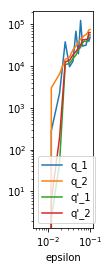

In [29]:
plt.plot(x, qq_1, label='q_1')
plt.plot(x, qq_2, label='q_2')
plt.plot(x, qprime_1, label="q'_1")
plt.plot(x, qprime_2, label="q'_2")

plt.yscale('log')
plt.xscale('log')
plt.axis('scaled')

plt.xlabel('epsilon')
plt.legend()
plt.show()

In [24]:
filepath = filename[1]
true_freq = true_frequency(filepath)

x = np.linspace(1e-30, 1e-1, num=30)
qq_1 = []
qq_2 = []
qprime_1 = []
qprime_2 = []
for delta in x:
    a, b, c, d = analyze(filepath, true_freq, eps=1e-2, delta=delta)
    qq_1.append(a)
    qq_2.append(b)
    qprime_1.append(c)
    qprime_2.append(d)

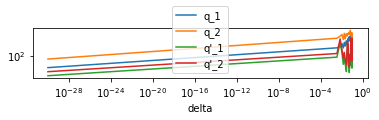

In [26]:
plt.plot(x, qq_1, label='q_1')
plt.plot(x, qq_2, label='q_2')
plt.plot(x, qprime_1, label="q'_1")
plt.plot(x, qprime_2, label="q'_2")

plt.yscale('log')
plt.xscale('log')
plt.axis('scaled')

plt.xlabel('delta')
plt.legend()
plt.show()